In [11]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [12]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [13]:
torch.backends.cudnn.benchmark=True

## Data

In [14]:
PATH = Path('../data/Train')

In [15]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [16]:
VEHICLES=10
ROADS=7

In [17]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64

### Create dataloader

In [18]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    y_new[y_img[:,:,2]==ROADS] = 2
    return y_new.astype(np.int64)

In [19]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [21]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 3
    def get(self, tfm, x, y):
        x,y = super().get(tfm, x, y)
        return x,y[0]

In [ ]:
def get_data(train_path, mask_path, bs):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    print(len(x_names), len(y_names))
    val_idxs = list(range(100))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    denorm = md.trn_ds.denorm
    return md

In [22]:
x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
print(len(x_names), len(y_names))

1000 1000


In [23]:
bs=128

In [24]:
VEHICLES=10
ROADS=7

In [25]:
val_idxs = list(range(100))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [26]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [27]:
# tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64
nw = 16

In [90]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [28]:
f = resnet34
cut,lr_cut = model_meta[f]

In [29]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [31]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [86]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 3, 2, stride=2))
        
    def forward(self,x): 
        out = self.features(x)
        return out

In [87]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [88]:
m_base = get_base()

In [89]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

## After testing

In [91]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.CrossEntropyLoss()
# learn.metrics=[accuracy_thresh(0.5),dice]
learn.metrics=[new_acc,dice]

In [92]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('BatchNorm2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_para

In [93]:
learn.freeze_to(1)

In [94]:
# %pdb on

epoch      trn_loss   val_loss   new_acc    dice        
    0      1.731295   inf        0.589986   0.286916  



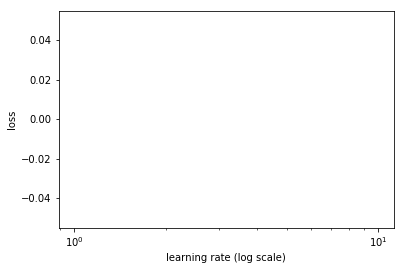

In [95]:
learn.lr_find()
learn.sched.plot()

In [96]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [97]:
learn.fit(lr,1, wds=wd, cycle_len=10,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice        
    0      1.087222   16155098.0 0.646993   0.0       
    1      0.889039   43741.859375 0.646993   0.0        
    2      0.680119   4.614825   0.684807   0.132567     
    3      0.556279   0.407927   0.87621    1.24504      
    4      0.469467   0.281686   0.905769   1.351235     
    5      0.40286    0.173213   0.940278   1.540504     
    6      0.353104   0.185855   0.936423   1.496838     
    7      0.314449   0.142622   0.954697   1.584074     
    8      0.28433    0.140369   0.956262   1.589123     
    9      0.259319   0.130792   0.961073   1.613561     



[array([0.13079]), 0.9610729813575745, 1.6135611811942296]

In [ ]:
learn.save('tmp')

In [ ]:
learn.load('tmp')

In [57]:
learn.unfreeze()
learn.bn_freeze(True)

In [58]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice         
    0      0.492016   0.28569    0.895966   1.477144  
    1      0.408273   0.233039   0.928495   1.475895     
    2      0.351236   0.194763   0.935242   1.52837      
    3      0.307372   0.165935   0.948246   1.569727     



[array([0.16593]), 0.9482464790344238, 1.5697274277130548]

In [ ]:
learn.save('128')

In [59]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [76]:
ix = np.argmax(py,1)

In [62]:
py.shape

(100, 3, 128, 128)

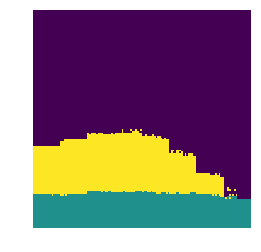

In [79]:
show_img(ix[0]);

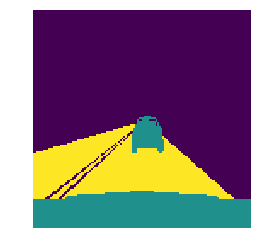

In [74]:
show_img(y[0]);

## U-net (ish)

In [98]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [99]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [101]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [102]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [103]:
m_base = get_base()

In [104]:
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [105]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.CrossEntropyLoss()
learn.metrics=[new_acc, dice]

In [107]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    dice         
    0      0.937682   5.312861765988587e+29 0.226639   0.72687   



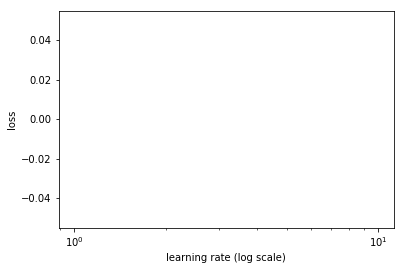

In [108]:
learn.lr_find()
learn.sched.plot()

In [109]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [110]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    dice         
    0      0.676406   8600.042969 0.423188   0.747831  
    1      0.406799   5.397849   0.679595   1.118706     
    2      0.290515   0.721322   0.834564   1.362568     
    3      0.226987   0.180857   0.943357   1.572958     
    4      0.187689   0.093495   0.967291   1.620556     
    5      0.160282   0.056413   0.979767   1.651852     
    6      0.140165   0.048683   0.983586   1.66092      
    7      0.124437   0.055089   0.981163   1.658773     



[array([0.05509]), 0.9811633229255676, 1.6587725964699553]

In [111]:
learn.save('128urn-tmp')

In [112]:
learn.load('128urn-tmp')

In [113]:
learn.unfreeze()
learn.bn_freeze(True)

In [114]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice          
    0      0.069847   0.046822   0.984489   1.662815  
    1      0.06629    0.042983   0.985963   1.667625      
    2      0.063137   0.040396   0.986406   1.664578      
    3      0.062663   0.040418   0.987149   1.668591      
    4      0.060942   0.040843   0.986669   1.669341      
    5      0.059089   0.038562   0.98752    1.670794      
    6      0.057809   0.037491   0.987703   1.669882      
    7      0.056468   0.037037   0.988013   1.669653      
    8      0.055499   0.035506   0.988458   1.671044      
    9      0.054495   0.035697   0.988474   1.671588      



[array([0.0357]), 0.9884741306304932, 1.6715879261394055]

In [115]:
learn.save('128urn-0')

In [116]:
learn.load('128urn-0')

In [117]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [118]:
py = np.argmax(py,1)

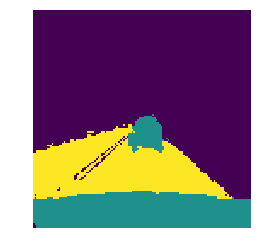

In [120]:
show_img(py[0]);

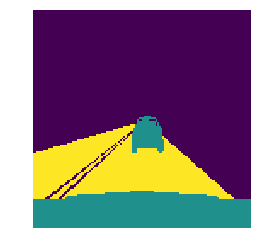

In [121]:
show_img(y[0]);

In [122]:
m.close()

## 256x256

In [123]:
TRAIN_DN = 'CameraRGB-256'
MASKS_DN = 'CameraSeg-256'

In [124]:
sz=256
bs=64

In [ ]:
x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
print(len(x_names), len(y_names))

In [ ]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.load('128urn-0')

In [ ]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

In [ ]:
learn.save('512urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.load('512urn-tmp')

In [ ]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512urn')

In [ ]:
learn.load('512urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 1024x1024

In [ ]:
sz=1024
bs=4

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [ ]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [ ]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [ ]:
learn.load('512urn')

In [ ]:
learn.freeze_to(1)

In [ ]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

In [ ]:
learn.save('1024urn-tmp')

In [ ]:
learn.load('1024urn-tmp')

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/200,lr/30,lr])

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('1024urn')

In [ ]:
learn.load('1024urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);